In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from mpl_toolkits.mplot3d import Axes3D
import pylab
import itertools
import matplotlib as mpl
from scipy import linalg

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('data/Test_data_07_11_2015.csv',sep=',')

In [3]:
X = df[["V1","V2","V3","I1","I2","I3","Pges","Sges","CosPhi"]]

In [4]:
r = X.rolling(60).mean()


In [5]:
data_smooth = pd.DataFrame(r.iloc[59:,:])
data_smooth.shape

(76071, 9)

plt.hist(data_smooth.iloc[:,0],bins=1000)
plt.show()

# PCA Based Anomaly Detection 

In [6]:
X_std = StandardScaler().fit_transform(data_smooth)

In [7]:
sklearn_pca = PCA(n_components=9)
Y_sklearn = sklearn_pca.fit_transform(X_std)

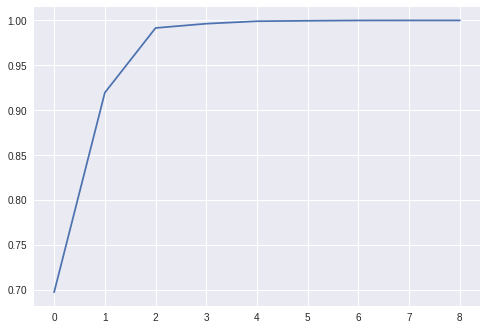

In [8]:
plt.plot(sklearn_pca.explained_variance_ratio_.cumsum())

# Method to calculate the PCA which captures very less variance

In [9]:
class PCA_decomp:
    def __init__(self):
        self.e_values = None
        self.e_vectors = None
        self.mean_data = None

    # Find all eigenvalues and eigenvectors
    # data -> instances as rows
    def prepare(self, data):
        # Substract mean
        self.mean_data = np.mean(data, axis=0)
        adj_data = data - self.mean_data
        # Covariance matrix
        covariance = np.cov(adj_data.T)
        # Eigenstuff
        self.e_values, self.e_vectors = np.linalg.eig(covariance)
        i = np.argsort(self.e_values)
        i = i[::-1]
        self.e_vectors = self.e_vectors[:,i]
        self.e_values = self.e_values[i]
        # Print the coverage of variance
        table = pd.DataFrame(index=['eVal','eTotal', 'Idiv%', '%'], columns=list(range(len(self.e_values))))
        current_val = 0
        total_val = np.sum(self.e_values)
        for i, val in enumerate(self.e_values):
            current_val += val
            table[i] = [val, current_val, val/total_val, current_val/total_val]
        print('Coverage of Variance:')
        print(table)
        print("\n")
        return table

    # Project the data into the normal or abnormal subspace
    def project(self, data, dimensions, normal_subspace=True):
        adj_data = data - self.mean_data
        if normal_subspace:
            # Extract only the top most eigenvectors
            e_vectors = self.e_vectors[:,:dimensions]
        else:
            # Extract the smallers eigenvectors as the anomalous part
            e_vectors = self.e_vectors[:,dimensions:]
        # Return the projected data
        return np.dot(adj_data, e_vectors)

    def revert(self, projected_data, dimensions):
        e_vectors = self.e_vectors[:,:dimensions]
        return np.dot(projected_data, e_vectors.T) + self.mean_data

In [10]:
a = PCA_decomp()
df_pca = a.prepare(X_std)

Coverage of Variance:
               0         1         2         3         4         5         6  \
eVal    6.276633  1.999516  0.648243  0.042887  0.024598  0.004565  0.003294   
eTotal  6.276633  8.276150  8.924393  8.967280  8.991878  8.996443  8.999737   
Idiv%   0.697395  0.222166  0.072026  0.004765  0.002733  0.000507  0.000366   
%       0.697395  0.919560  0.991586  0.996351  0.999084  0.999592  0.999958   

               7         8  
eVal    0.000350  0.000031  
eTotal  9.000087  9.000118  
Idiv%   0.000039  0.000003  
%       0.999997  1.000000  




Split the PCA components into normal and abnormal depending on the variance. The first 4 components capture most of the variances as can be seen from the *sklearn_pca.explained_variance_ratio_.cumsum()* plot and hence, will be considered as **normal** and rest as **abnormal**

In [11]:
df_pca_abnormal = a.project(X_std,3,normal_subspace=False)

In [12]:
df_pca_abnormal.shape

(76071, 6)

In [13]:
df_pca_abnormal[:5]

array([[  2.69264636e-01,  -2.07164954e-01,   1.04851762e-01,
         -1.68966308e-02,  -5.25643411e-03,   2.44004487e-04],
       [  2.71388242e-01,  -2.08410476e-01,   1.04465838e-01,
         -1.61525340e-02,  -5.06404054e-03,   3.03346819e-04],
       [  2.73152731e-01,  -2.10580055e-01,   1.04524660e-01,
         -1.57509917e-02,  -4.58404076e-03,   2.63105162e-04],
       [  2.74555708e-01,  -2.10709639e-01,   1.04115024e-01,
         -1.46279301e-02,  -4.25965581e-03,   3.18537134e-04],
       [  2.78646687e-01,  -2.12480742e-01,   1.02251218e-01,
         -1.41609908e-02,  -3.93924994e-03,   3.30009399e-04]])

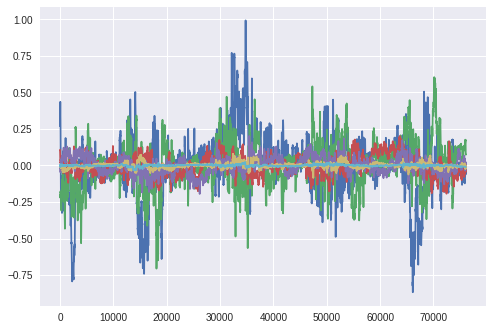

In [14]:
plt.plot(df_pca_abnormal)
plt.show()

# Calculate the Squared Prediction Error

$$ y = ŷ + ỹ $$



$$ŷ = PP^Ty = Cy$$ and $$ỹ = I − PP^T y = C̃y $$


$$ \textbf{SPE} ≡  \parallel ỹ \space \parallel ^ 2 $$

$$ \delta^2_\alpha == \phi_1 \Bigg[ \frac{c_\alpha\sqrt{2\phi_2 h^2_0}}{\phi_1} + 1 + \frac{ \phi_2 h_0(h_0 -1)}{\phi_1 ^ 2} \Bigg]^\frac{1}{h_0} $$

$$\phi_i=\sum_{j=r+1}^m \lambda^i_j \quad for \quad i = 1,2,3 $$

$$ h_0 = 1 - \frac{2\phi_1 \phi_3}{3\phi_2 ^2} $$

In [15]:
def calc_spe(data):
    norm_val = np.linalg.norm(data,axis=1)
    SPE = norm_val * norm_val
    return SPE

In [16]:
spe_err = calc_spe(df_pca_abnormal)
spe_err

array([ 0.12672784,  0.12828626,  0.13015095, ...,  0.00747462,
        0.00747891,  0.00757282])

In [17]:
spe_err.shape[0]

76071

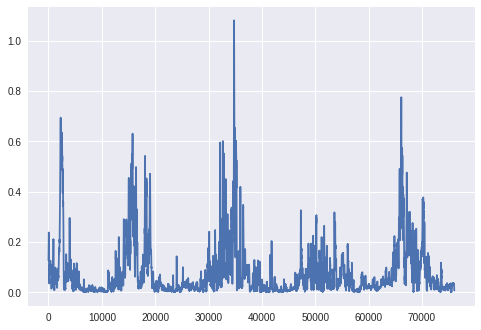

In [18]:
plt.plot(spe_err)

In [47]:
count = 0
spe_err_gt = []
for i in range(spe_err.shape[0]):
    if spe_err[i] > 0.7:
        count = count + 1
        spe_err_gt.append(i)
print count

116


In [48]:
spe_err_gt #red above 1.0 and yellow above 1.5

[34754,
 34755,
 34756,
 34757,
 34758,
 34759,
 34760,
 34761,
 34762,
 34763,
 34764,
 34765,
 34766,
 34767,
 34768,
 34769,
 34770,
 34771,
 34772,
 34773,
 34774,
 34775,
 34776,
 34777,
 34778,
 34779,
 34780,
 34781,
 34782,
 34783,
 34784,
 34785,
 34786,
 34787,
 34788,
 34789,
 34790,
 34791,
 34792,
 34793,
 34794,
 34795,
 34796,
 34797,
 34798,
 34799,
 34800,
 34801,
 34802,
 34803,
 34804,
 34805,
 34806,
 34807,
 34808,
 34809,
 34810,
 34811,
 34812,
 34813,
 34814,
 34815,
 34816,
 34817,
 34818,
 34819,
 34820,
 34821,
 34822,
 34823,
 34824,
 34825,
 34826,
 34827,
 34828,
 34829,
 34830,
 34831,
 34832,
 34833,
 34834,
 34835,
 34836,
 34837,
 34838,
 34839,
 34840,
 34841,
 34842,
 66118,
 66119,
 66120,
 66121,
 66122,
 66123,
 66124,
 66125,
 66126,
 66127,
 66128,
 66129,
 66130,
 66131,
 66132,
 66133,
 66134,
 66135,
 66136,
 66137,
 66138,
 66139,
 66140,
 66141,
 66142,
 66143,
 66144]

# Calculate the Q-threshold

Remember eigen values are in descending order

In [35]:
eig_vals = df_pca.iloc[0,:]
eig_vals# gives the eigen values of the residual PCA components

0    6.276633
1    1.999516
2    0.648243
3    0.042887
4    0.024598
5    0.004565
6    0.003294
7    0.000350
8    0.000031
Name: eVal, dtype: float64

$$\phi_i=\sum_{j=r+1}^m \lambda^i_j \quad for \quad i = 1,2,3 $$

In [36]:
list_eig = []
for i in (1,2,3):
    print i
    eig_vals_j = 0
    for j in range(7, X.shape[1]):
        print j
        eig_vals_j += eig_vals[j]
    list_eig.append(np.power(eig_vals_j,i))
    print list_eig

1
7
8
[0.00038091139815403903]
2
7
8
[0.00038091139815403903, 1.4509349324366486e-07]
3
7
8
[0.00038091139815403903, 1.4509349324366486e-07, 5.5267765374497992e-11]


In [37]:
list_eig

[0.00038091139815403903, 1.4509349324366486e-07, 5.5267765374497992e-11]

In [38]:
phi_1,phi_2,phi_3 = list_eig[0],list_eig[1],list_eig[2]

In [39]:
phi_1

0.00038091139815403903

$$ h_0 = 1 - \frac{2\phi_1 \phi_3}{3\phi_2 ^2} $$

In [40]:
h0 = 1 - (float(2 * phi_1 * phi_3)/float(3 * phi_2 * phi_2))

In [41]:
h0

0.3333333333333335

In [42]:
h0 = 0.0000000003

$$ \delta^2_\alpha == \phi_1 \Bigg[ \frac{c_\alpha\sqrt{2\phi_2 h^2_0}}{\phi_1} + 1 + \frac{ \phi_2 h_0(h_0 -1)}{\phi_1 ^ 2} \Bigg]^\frac{1}{h_0} $$

In [59]:
a = 6
b = np.sqrt(2 * phi_2 * h0 * h0)
c = phi_1
d = phi_2 * h0 * (h0 - 1)
e1 = float(1)/float(h0)
inner_brackets = np.power( (float(a * b)/float(c) + 1.0 + float(d)/float(c * c)),e1)
threshold = ( c * inner_brackets )

In [60]:
threshold

0.67864135600011399

In [61]:
count = 0
spe_ex_thr = []
for i in range(spe_err.shape[0]):
    if spe_err[i] > threshold:
        count = count + 1
        spe_ex_thr.append(i)
print count

148


In [62]:
spe_ex_thr

[2264,
 2265,
 2266,
 2267,
 2268,
 2269,
 2270,
 2271,
 2272,
 2273,
 2274,
 2275,
 2276,
 2277,
 2278,
 2279,
 2280,
 2281,
 2282,
 34754,
 34755,
 34756,
 34757,
 34758,
 34759,
 34760,
 34761,
 34762,
 34763,
 34764,
 34765,
 34766,
 34767,
 34768,
 34769,
 34770,
 34771,
 34772,
 34773,
 34774,
 34775,
 34776,
 34777,
 34778,
 34779,
 34780,
 34781,
 34782,
 34783,
 34784,
 34785,
 34786,
 34787,
 34788,
 34789,
 34790,
 34791,
 34792,
 34793,
 34794,
 34795,
 34796,
 34797,
 34798,
 34799,
 34800,
 34801,
 34802,
 34803,
 34804,
 34805,
 34806,
 34807,
 34808,
 34809,
 34810,
 34811,
 34812,
 34813,
 34814,
 34815,
 34816,
 34817,
 34818,
 34819,
 34820,
 34821,
 34822,
 34823,
 34824,
 34825,
 34826,
 34827,
 34828,
 34829,
 34830,
 34831,
 34832,
 34833,
 34834,
 34835,
 34836,
 34837,
 34838,
 34839,
 34840,
 34841,
 34842,
 34843,
 34844,
 34845,
 66092,
 66093,
 66094,
 66095,
 66115,
 66116,
 66117,
 66118,
 66119,
 66120,
 66121,
 66122,
 66123,
 66124,
 66125,
 66126,
 66